In [1]:
import h5py
import core.init as init
import core.utility as utility
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv as jv
import cycler

# Part to change plotting system
# Slows things down a little but makes nicer plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,6)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})
plt.rc('text', usetex=True)
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
# Parameters
L = 24                          # Linear system size
dim = 1                         # Spatial dimension
n = L**dim                      # Total number of sites
species = 'spinless fermion'    # Type of particle
dsymm = 'charge'                # Type of disorder (spinful fermions only)
Ulist = [0.1]
# List of interaction strengths
J = 1.0                         # Nearest-neighbour hopping amplitude
cutoff = J*10**(-3)             # Cutoff for the off-diagonal elements to be considered zero
dis = [0.7+0.05*i for i in range(11)]
# List of disorder strengths
lmax = 500                      # Flow time max
qmax = 2500                     # Max number of flow time steps
reps = 1                        # Number of disorder realisations
norm = False                    # Normal-ordering, can be true or false
intr = True                     # Turn on/off interactions
dyn = False
imbalance = True                # Sets whether to compute global imbalance or single-site dynamics
LIOM = 'bck'                    # Compute LIOMs with forward ('fwd') or backward ('bck') flow
                                # Forward uses less memory by a factor of qmax, and transforms a local operator
                                # in the initial basis into the diagonal basis; backward does the reverse
dis_type = 'linear'             # Options: 'random', 'QPgolden', 'QPsilver', 'QPbronze', 'QPrandom', 'linear', 'curved', 'prime'
                                # Also contains 'test' and 'QPtest', potentials that do not change from run to run
xlist = [0.1*i for i in range(1,10)]
# For 'dis_type = curved', controls the gradient of the curvature
if intr == False:               # Zero the interactions if set to False (for ED comparison and filename)
    delta = 0
if dis_type != 'curved':
    xlist = [0.0]

# Make directory to store data
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)


## Analytic Solution for Linear Slope

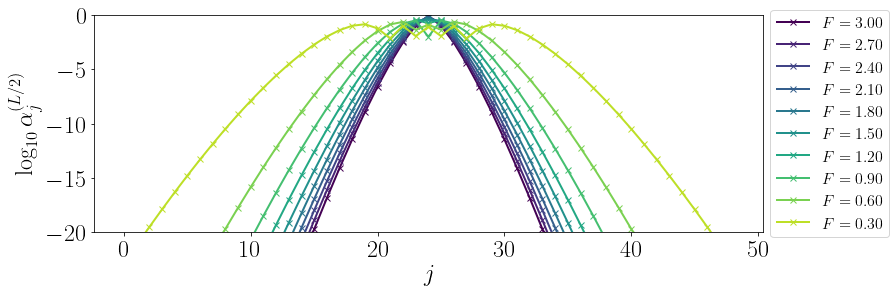

In [3]:
nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n=24
for d in [0.3*i for i in range(1,11)][::-1]:
    bessel = np.zeros(2*n+1)
    for i in range(2*n+1):
        bessel[i] = np.log10(np.abs(jv(np.abs(i-n),2/d)**2))
    plt.plot(bessel,'x-',linewidth='2',label=r'$F = %.2f$' %d)
plt.legend(loc='center right',bbox_to_anchor=(1.2,.5),fontsize=16)
plt.ylim(-20,0)
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.savefig('bessel.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of Numerical and Analytical Solutions

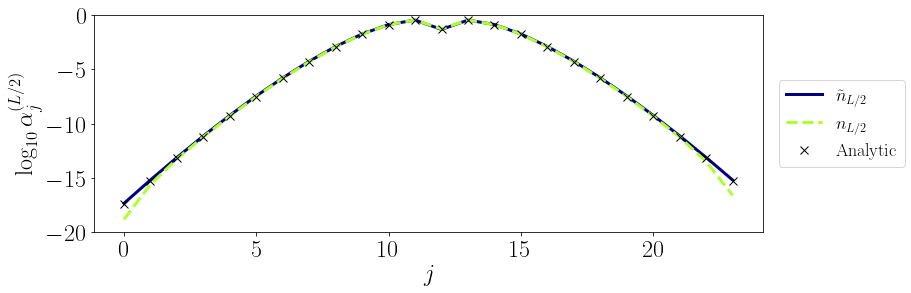

In [5]:
dis = [1.]
xlist = [0.0]
dis_type='linear'
n = 24

norm = False
LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,label=r'$\tilde{n}_{L/2}$',color='navy',linewidth='3')
            
LIOM = 'fwd'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'--',label='$n_{L/2}$',color='greenyellow',linewidth='3')
   
# norm = True
# LIOM = 'bck'
# nvar = utility.namevar(dis_type,dsymm,dyn,norm,n,LIOM,species)
# for d in dis:
#     for x in xlist:
#         for delta in Ulist:
#             with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
#                 liom = np.array(hf.get('liom'))
#                 liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
#             plt.plot(liom,'r')
            
# LIOM = 'fwd'
# nvar = utility.namevar(dis_type,dsymm,dyn,norm,n,LIOM,species)
# for d in dis:
#     for x in xlist:
#         for delta in Ulist:
#             with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
#                 liom = np.array(hf.get('liom'))
#                 liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
#             plt.plot(liom,'r--')
            

bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2)**2))
plt.plot(bessel,'kx',markersize='8',label=r'Analytic')
plt.legend(loc='center right',bbox_to_anchor=(1.225,.5),fontsize=18)
plt.ylim(-20,0)
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.savefig('bessel2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()
norm = False

## Summary of results for linear slope

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


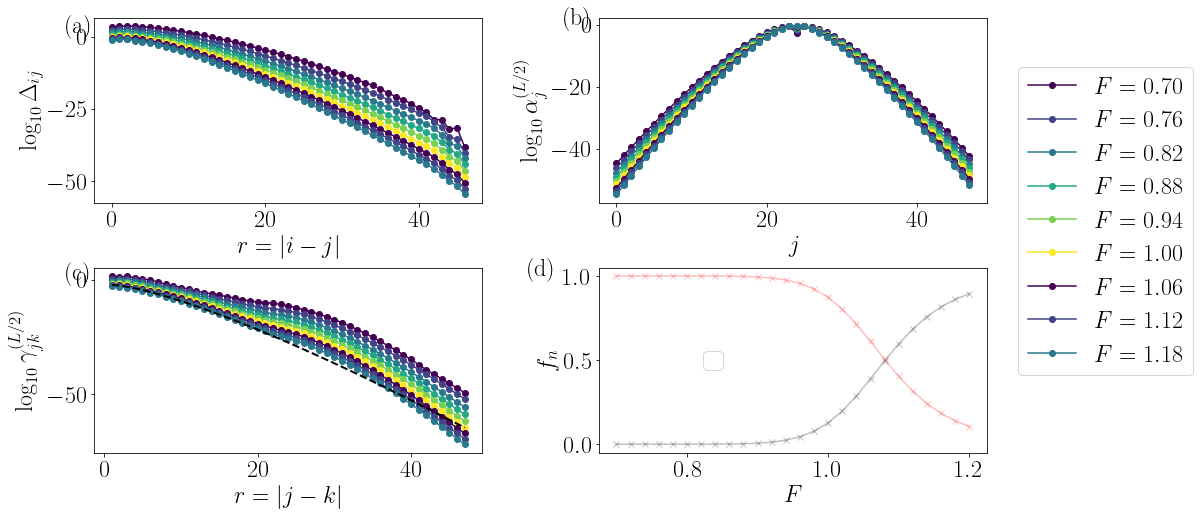

In [51]:
mpl.rcParams['figure.figsize'] = (16,8)

nc = 9
color = plt.cm.viridis(np.linspace(0, 1,nc))

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 48
dis = [0.7+0.06*i for i in range(9)]
xlist = [0.0]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'linear'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                lbits = np.array(hf.get('lbits'))
                error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-6.,1.5,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(0.1*np.abs(jv(np.abs(i),2/d)**(3/2)))
# ax1.plot(bessel,'k--',markersize='8',linewidth='2')

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$F= %.2f$' %d)
            
ax2.text(-7,-0.,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                Hint = np.array(hf.get('Hint'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)
            Hint = Hint.reshape(n,n,n,n)
            

            mat = np.ones((n,n))    
            
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0
            l4_list = np.zeros(n-1)
            Hint = Hint.reshape(n**4)
#             print(np.sort(np.abs(Hint))[-30:])
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
bx1.text(-5.,-0.0,r'(c)')
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()

bessel = np.zeros(n-1)
for i in range(1,n):
    bessel[i-1] = np.log10(0.01*np.abs(jv(np.abs(i),2/d)))
bx1.plot(range(1,n),bessel,'k--',markersize='8',linewidth='2')


dis = [0.7+0.02*i for i in range(26)]
for n in [24]:
    
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)

    f2list = np.zeros(len(dis))
    f4list = np.zeros(len(dis))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    if n == 48:
        bx2.plot(dis,f2list,'kx-',alpha=n/96,label=r'$f_2$')
        bx2.plot(dis,f4list,'rx-',alpha=n/96,label=r'$f_4$')
    else:
        bx2.plot(dis,f2list,'kx-',alpha=n/96)
        bx2.plot(dis,f4list,'rx-',alpha=n/96)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$F$')
bx2.text(0.575,1.0,r'(d)')
bx2.legend(loc='center right',bbox_to_anchor=(0.35,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.1))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('linear.png',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

fermion/data/linear/PT/fwd/static/dataN8
fermion/data/linear/PT/fwd/static/dataN12
fermion/data/linear/PT/fwd/static/dataN24
fermion/data/linear/PT/fwd/static/dataN36
fermion/data/linear/PT/fwd/static/dataN48


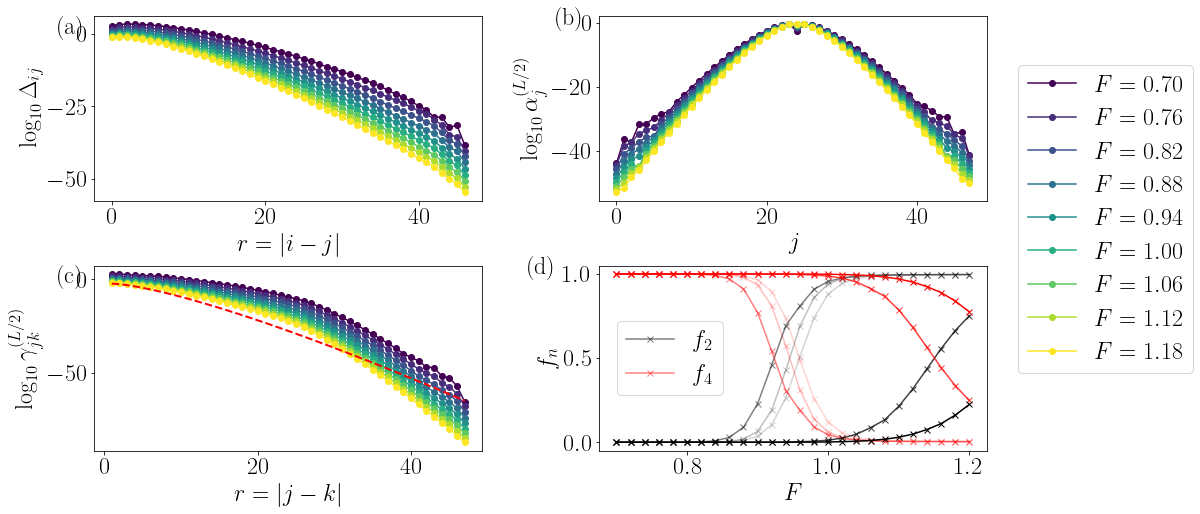

In [89]:
mpl.rcParams['figure.figsize'] = (16,8)

nc = 9
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 48
dis = [0.7+0.06*i for i in range(9)]
xlist = [0.0]
LIOM = 'fwd'
norm = False
species = 'spinless fermion'
dis_type = 'linear'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                lbits = np.array(hf.get('lbits'))
                error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-7,-0.0,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()


# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(0.1*np.abs(jv(np.abs(i),2/d)**(3/2)))
# ax1.plot(bessel,'k--',markersize='8',linewidth='2')


# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$F= %.2f$' %d)
            
ax2.text(-8,-0.75,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
bx1.text(-6,-1.8,r'(c)')
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()

bessel = np.zeros(n-1)
for i in range(1,n):
    bessel[i-1] = np.log10((0.01*np.abs(jv(np.abs(i),2/d)))**(1))
bx1.plot(range(1,n),bessel,'r--',markersize='8',linewidth='2')

dis = [0.7+0.02*i for i in range(26)]
for n in [8,12,24,36,48]:
    
    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
    print(nvar)

    f2list = np.zeros(len(dis))
    f4list = np.zeros(len(dis))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

        f2list[count] = f2
        f4list[count] = f4

        count += 1
        
#     print(n,f2list)
#     print(n,f4list)

    if n == 24:
        bx2.plot(dis,f2list,'kx-',alpha=n/48,label=r'$f_2$')
        bx2.plot(dis,f4list,'rx-',alpha=n/48,label=r'$f_4$')
    else:
        bx2.plot(dis,f2list,'kx-',alpha=n/48)
        bx2.plot(dis,f4list,'rx-',alpha=n/48)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$F$')
bx2.text(0.575,1.0,r'(d)')
bx2.legend(loc='center right',bbox_to_anchor=(0.35,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.1))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('linear_fwd.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of 'forward' and 'backward' LIOMs

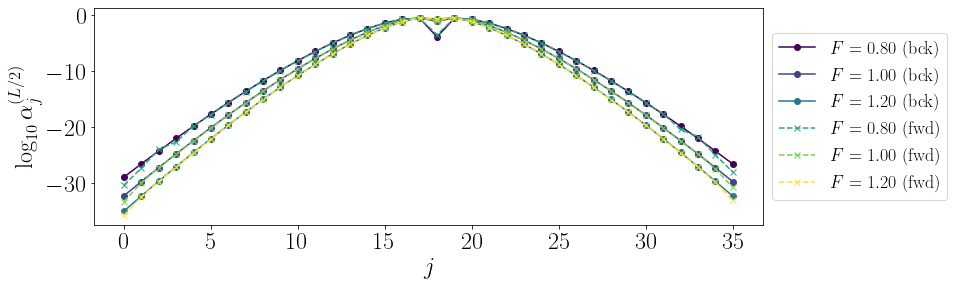

In [9]:
n=36
dis = [0.8,1.00,1.2]
nc = 6
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'o-',label=r'$F = %.2f$ (bck)' %d)
            
LIOM = 'fwd'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                liom = np.array(hf.get('liom'))
                liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
            plt.plot(liom,'x--',label=r'$F = %.2f$ (fwd)' %d)
            
plt.ylabel(r'$\log_{10} \alpha^{(L/2)}_j$')
plt.xlabel(r'$j$')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5),fontsize=18)
plt.show()
plt.close()

## Summary of results for curved potential

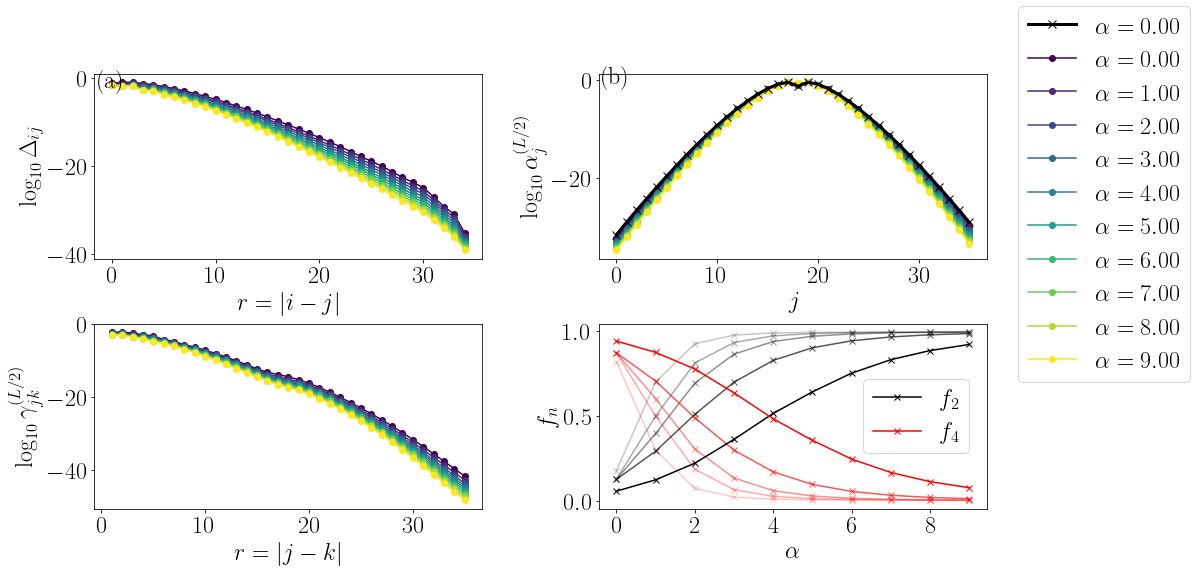

In [9]:
mpl.rcParams['figure.figsize'] = (16,8)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

nc = 10
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 36
dis = [1.0]
xlist = [1.0*i for i in range(10)]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'curved'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.text(-1.3,-2.0,r'(a)')
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

bessel = np.zeros(n)
for i in range(n):
    bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
            liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$\alpha= %.2f$' %x)
            
ax2.text(-1.4,-0.75,r'(b)')
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()


for n in [8,12,16,24,36]:

    f2list = np.zeros(len(xlist))
    f4list = np.zeros(len(xlist))
    count = 0
    for d in dis:
        for x in xlist:
            for delta in Ulist:
                if x == 0.0:
                    dis_type = 'linear'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                else:
                    dis_type='curved'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

            f2list[count] = f2
            f4list[count] = f4

            count += 1

    if n == 36:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36,label=r'$f_2$')
        bx2.plot(xlist,f4list,'rx-',alpha=n/36,label=r'$f_4$')
    else:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36)
        bx2.plot(xlist,f4list,'rx-',alpha=n/36)
    
bx2.set(ylabel=r'$f_n$',xlabel=r'$\alpha$')
bx2.legend(loc='center left',bbox_to_anchor=(0.65,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,0.35))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('curved.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

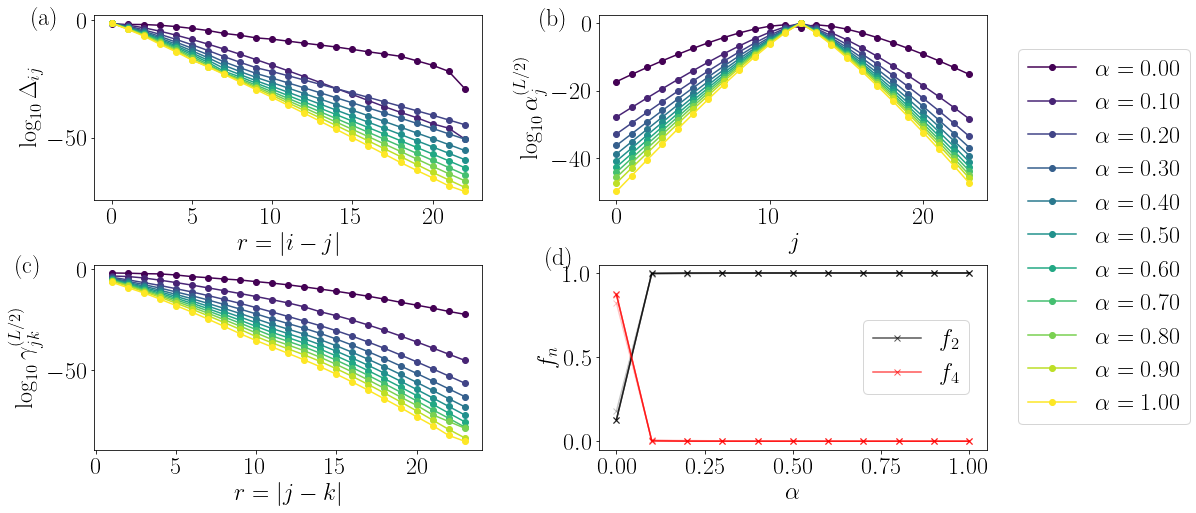

In [28]:
mpl.rcParams['figure.figsize'] = (16,8)

fig, axes = plt.subplots(2,2)
ax1,ax2 = axes[0]
bx1,bx2 = axes[1]

nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
mpl.rcParams['figure.figsize'] = (12,4)
plt.rc('font',family='serif')
plt.rcParams.update({'font.size': 24})

n = 24
dis = [1.0]
xlist = [0.1*i for i in range(11)]
LIOM = 'bck'
norm = False
species = 'spinless fermion'
dis_type = 'curved2'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    lbits = np.array(hf.get('lbits'))
                    error = np.array(hf.get('err'))
#                 print(d,np.mean(error))
            ax1.plot(lbits,'o-')
# plt.legend(loc='center left',bbox_to_anchor=(1,0.5))
ax1.set(ylabel=r'$\log_{10} \Delta_{ij}$',xlabel=r'$r=|i-j|$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.xlabel(r'$r=|i-j|$')
# plt.show()
# plt.close()

# bessel = np.zeros(n)
# for i in range(n):
#     bessel[i] = np.log10(np.abs(jv(np.abs(i-n//2),2/d)**2))
# ax2.plot(bessel,'kx-',markersize='8',linewidth='3',label=r'$\alpha=0.00$',zorder=30)

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
#                 print(d,np.trace(liom[:n**2].reshape(n,n)))
            liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                
            ax2.plot(liom,'o-',label=r'$\alpha= %.2f$' %x)
            
ax2.set(ylabel=r'$\log_{10} \alpha^{(L/2)}_j$',xlabel=r'$j$')

for d in dis:
    for x in xlist:
        for delta in Ulist:
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            else:
                dis_type='curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom'))
            l4 = liom[n**2:n**2+n**4].reshape(n,n,n,n)

            mat = np.ones((n,n))    
            for i in range(n):              
                for j in range(n):
                    if i != j:
                        # Load dHint_diag with diagonal values (n_i n_j or c^dag_i c_j c^dag_j c_i)
                        mat[i,j] = l4[i,i,j,j]
                        mat[i,j] = -l4[i,j,j,i]
            l4_list = np.zeros(n-1)
            for k in range(1,n):
                l4_list[k-1] = np.mean(np.abs(np.diag(mat,k)))

        bx1.plot(range(1,n),np.log10(np.abs(l4_list)),'o-')
bx1.set(ylabel=r'$\log_{10} \gamma^{(L/2)}_{jk}$',xlabel=r'$r=|j-k|$') 
# plt.legend(loc='center right',bbox_to_anchor=(1.3,0.5))
# plt.yscale('log')
# plt.xlabel(r'$r$')
# plt.ylabel(r'$\log_{10} \Delta_{ij}$')
# plt.show()
# plt.close()


for n in [8,12,16,24]:

    f2list = np.zeros(len(xlist))
    f4list = np.zeros(len(xlist))
    count = 0
    for d in dis:
        for x in [0.01]:
            for delta in Ulist:
                if x == 0.0:
                    dis_type = 'linear'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                else:
                    dis_type='curved2'
                    nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                    with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                        liom = np.array(hf.get('liom'))
                squared = np.sum([i**2 for i in liom])
                f2 = np.sum([i**2 for i in liom[:n**2]])/squared
                f4 = np.sum([i**2 for i in liom[n**2:]])/squared

            f2list[count] = f2
            f4list[count] = f4

            count += 1

    if n == 24:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36,label=r'$f_2$')
        bx2.plot(xlist,f4list,'rx-',alpha=n/36,label=r'$f_4$')
    else:
        bx2.plot(xlist,f2list,'kx-',alpha=n/36)
        bx2.plot(xlist,f4list,'rx-',alpha=n/36)
    
ax1.text(-5.,-2.0,r'(a)')
ax2.text(-5.,-0.75,r'(b)')
bx1.text(-5.,-2.0,r'(c)')
bx2.text(-0.2,1.05,r'(d)')
bx2.set(ylabel=r'$f_n$',xlabel=r'$\alpha$')
bx2.legend(loc='center left',bbox_to_anchor=(0.65,0.5))
ax2.legend(loc='center left',bbox_to_anchor=(1.05,-0.2))
# plt.tight_layout()
plt.subplots_adjust(hspace=0.35,wspace=0.3)
plt.savefig('curved2.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

## Comparison of curved and linear potentials

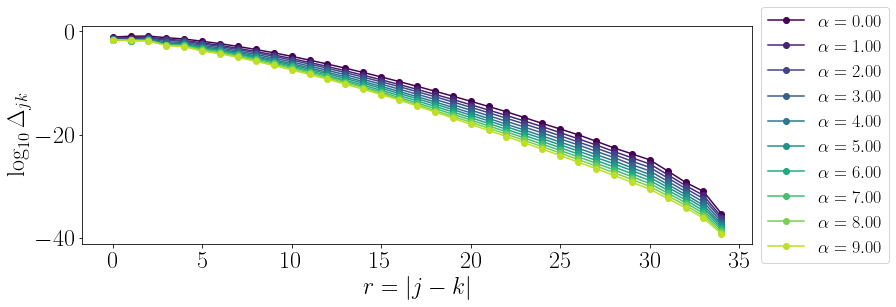

In [17]:
n = 36
dis = [1.00]
xlist = [1.0*i for i in range(10)]
nc = 11
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

LIOM = 'bck'
nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
for d in dis:
    for x in xlist:
        for delta in Ulist:
            
            if x == 0.0:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('lbits'))
#                     liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                plt.plot(liom,'o-',label=r'$\alpha = %.2f$' %x)
            
            else:
                dis_type = 'curved'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('lbits'))
#                     liom = np.log10(np.abs(np.diag(liom[:n**2].reshape(n,n))))
                plt.plot(liom,'o-',label=r'$\alpha = %.2f$' %x)
            

plt.ylabel(r'$\log_{10} \Delta_{jk}$')
plt.xlabel(r'$r=|j-k|$')
plt.legend(loc='center left',bbox_to_anchor=(1.0,0.5),fontsize=18)
plt.savefig('curved_delta.pdf',dpi=300,bbox_inches='tight')
plt.show()
plt.close()

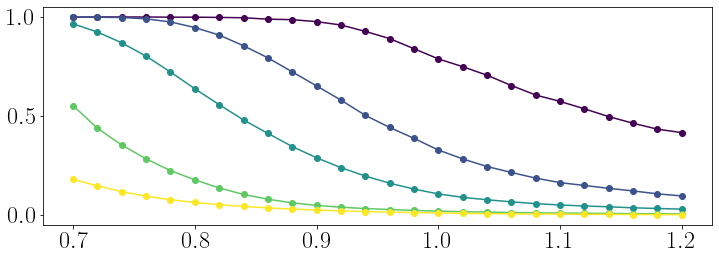

In [19]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 5
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24,36]:
    klist = np.zeros(len(dis))
    klist2 = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    liom = np.array(hf.get('liom')).reshape(n**2+n**4)

                for i in liom:
                    if np.abs(i)>10**(-3):
                        count += 1
                    if np.abs(i)>10**(-6):
                        count2 += 1
        klist[dcount] = count/(n**2+n**4)
        klist2[dcount] = count2/(n**2+n**4)
        dcount += 1
    plt.plot(dis,klist,'o-')
#     plt.plot(dis,klist2,'x--')
# plt.yscale('log')
plt.show()
plt.close()

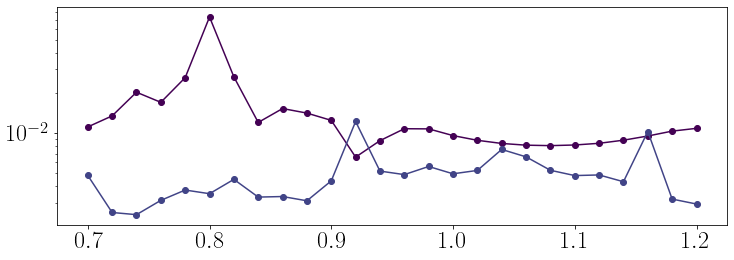

In [70]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'

for n in [8,12]:
    errlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    err = np.array(hf.get('err'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        errlist[dcount] = np.mean(err)
        dcount += 1
    plt.plot(dis,errlist,'o-')
#     plt.plot(dis,klist2,'x--')
plt.yscale('log')
plt.show()
plt.close()

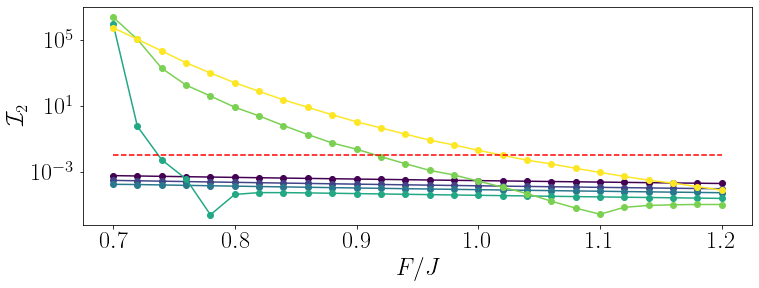

In [74]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'

for n in [8,12,16,24,36,48]:
    invlist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    inv = np.array(hf.get('inv'))
                    Hint = np.array(hf.get('Hint'))
#                     print(d,np.max(np.abs(Hint)))
        invlist[dcount] = inv
        dcount += 1
    plt.plot(dis,invlist,'o-')
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,0.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\mathcal{I}_2$')
plt.show()
plt.close()

8 0.0498046875 0.0166015625
12 0.047839506172839504 0.008680555555555556
16 0.04400634765625 0.00445556640625
24 0.03812210648148148 0.0016276041666666667
36 0.03957214029873495 0.002236225422953818
48 0.033932532793209874 0.00202734676408179


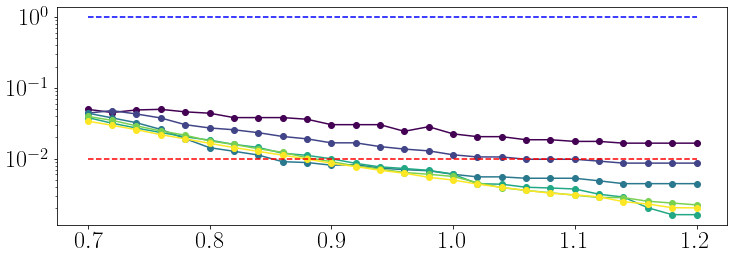

In [78]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 6
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24,36,48]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.
                        
                qcount = 0
                for q in np.abs(Hint.reshape(n**4)):
                    if q > 0.001:
                        qcount += 1

#         klist[dcount] = np.max(np.abs(Hint))
        klist[dcount] = qcount/n**4
        dcount += 1
    plt.plot(dis,klist,'o-')
    print(n,np.max(klist),np.min(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.yscale('log')
plt.show()
plt.close()

12 265.2360332415506
24 29257.431779803188
36 5286.742603495835
48 2798.190472386743


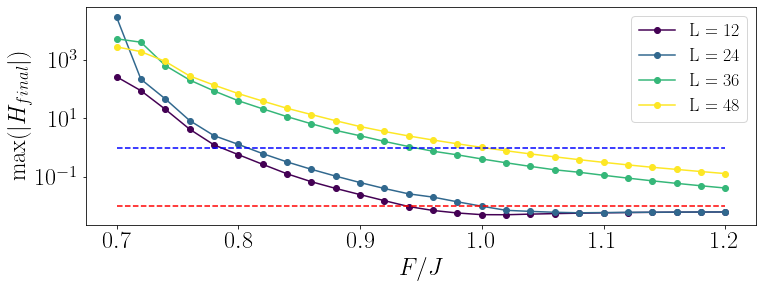

In [85]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 4
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [12,24,36,48]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.0]:
            for delta in Ulist:
                dis_type = 'linear'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.

        klist[dcount] = np.max(np.abs(Hint))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()

8 0.003339191773199987
12 0.015668041448127404
16 0.013366573363913609
24 0.004525205925812395


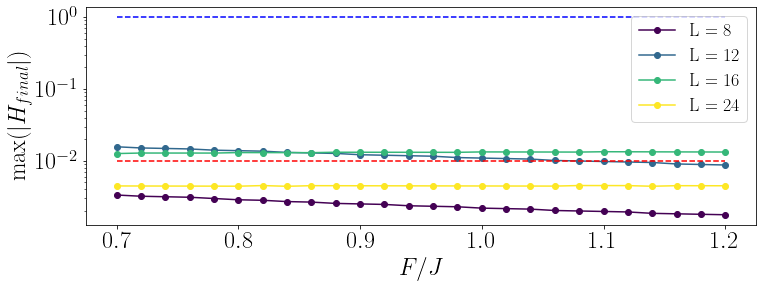

In [26]:
dis = [0.7+0.02*i for i in range(26)]
LIOM = 'bck'
nc = 4
color = plt.cm.viridis(np.linspace(0, 1,nc))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
for n in [8,12,16,24]:
    klist = np.zeros(len(dis))
    dcount = 0
    for d in dis:
        count = 0
        count2 = 0
        for x in [0.8]:
            for delta in Ulist:
                dis_type = 'curved2'
                nvar = utility.namevar(dis_type,dsymm,'CDW',dyn,norm,n,LIOM,species)
                with h5py.File('%s/tflow-d%.2f-x%.2f-Jz%.2f-p%s.h5' %(nvar,d,x,delta,0),'r') as hf:
                    Hint = np.array(hf.get('Hint'))
                    Hint = Hint.reshape(n,n,n,n)
                for i in range(n):
                    for j in range(n):
                        Hint[i,i,j,j] = 0.
                        Hint[i,j,j,i] = 0.

        klist[dcount] = np.max(np.abs(Hint))
        dcount += 1
    plt.plot(dis,klist,'o-',label=r'L = %s' %n)
    print(n,np.max(klist))
#     plt.plot(dis,klist2,'x--')
plt.plot(dis,np.ones(len(dis)),'b--')
plt.plot(dis,.01*np.ones(len(dis)),'r--')
plt.legend(fontsize=18)
plt.xlabel(r'$F/J$')
plt.ylabel(r'$\textrm{max}(|H_{final}|)$')
plt.yscale('log')
plt.show()
plt.close()